Utility Functions

In [14]:
import PIL.Image
import numpy as np
from matplotlib import pyplot as plt

def load_image(_path, _size):
    img = PIL.Image.open(_path)
    img = img.resize((_size, _size), PIL.Image.Resampling.BICUBIC)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]
    return img

def show_image(_img):
    assert len(_img.shape) == 3
    assert _img.shape[2] == 4
    plt.axis('off')
    plt.imshow(_img)
    plt.show()
    
def to_tensor(_img):
    pass
    
# def to_rgb(_img):
#     rgb, a = img_rgba[:, :3, ...], torch.clamp(img_rgba[:, 3:, ...], 0, 1)
#     return torch.clamp(rgb, 0, 1)

(40, 40, 4)


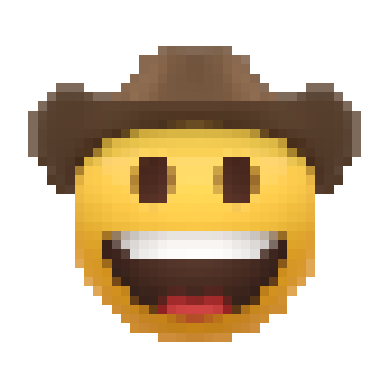

In [15]:
img = load_image('..\\_images\\cowboy.png', 40)
show_image(img)